# A brief explanation of the revamped CBRAIN module

In this guide, we will go through the steps required to preprocess the raw climate model output, train a neural network and then analyze how good it is.

In [13]:
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *

## Preprocessing

Preprocessing works using the `preprocessing.py` script in the main directory of the repository along with a configuration file. Let's have a look at one such configuration file to see what is required.

Here is `000_test.yml`:

```yaml
vars : [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX, PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic]

in_dir : /local/S.Rasp/sp32fbp_andkua/
in_fns : AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-0*-00000.nc

out_dir: /local/S.Rasp/preprocessed_data/
out_fn: 000_train.nc

val_in_fns: AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-02-0*-00000.nc
val_out_fn: 000_valid.nc

norm_fn: 000_norm.nc
```

One new thing is that it is not necessary to specifically state the input and output variables at the preprocessing script. These will be chosen later in the data generator. This mean that `vars` can contain as many variables as possible. This should reduce the number of times the preprocessing has to be run.

Some of the variables are saved directly in the model output, e.g. `PHQ`, while others, e.g. `QBP` have to be derived. Currently, the following derived variables are available: `*dt_adiabatic`, `*BP` and `PRECST`. If you want to add others, you have to implement it in `convert_dataset.py`.

`in_dir` and `in_fns` describe the raw climate model file names. `out_dir` and `out_fn` denote the path to the preprocessed file. 

The training dataset will additionally be preshuffled.

If `val_*` is given, a separate validation dataset will be created.

If `norm_fn` is given, statistics will be computed from the training dataset, e.g. the mean and standard deviation.  Note that for large training files this takes a very, very long time. Therefore, I recommend computing the normalization file on a small dataset and use it for the large training dataset.

In [3]:
!python preprocessing.py -c pp_config/000_test.yml

2019-04-03 14:52:26.858479: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-04-03 14:52:27.047180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 6.04GiB
2019-04-03 14:52:27.047219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-04-03 14:52:39.252462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-04-03 14:52:39.253048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-04-03 14:52:39.253084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-04-03 14:52:39.253949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorF

In [6]:
!ls /local/S.Rasp/preprocessed_data/000*

/local/S.Rasp/preprocessed_data/000_norm.nc
/local/S.Rasp/preprocessed_data/000_train.nc
/local/S.Rasp/preprocessed_data/000_train_shuffle.nc
/local/S.Rasp/preprocessed_data/000_valid.nc


## Training the model step-by-step

Let's now go through the steps to train a neural network starting with the new data generator.

### Data generator

To read the preprocessed file and feed the data to the neural net, we will use the `DataGenerator` class in the cbrain module. 

At this stage we will not define the variables we want in the input and output of the neural network.

In [7]:
in_vars = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [8]:
out_vars = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

Next we need to think about how we want to normalize/scale the inputs and outputs. 

For the inputs we will use a pretty standard normalization, which we will get to later.

As for the outputs, we would like to scale each variable physically. For this we will create a dictionary, which will contain a factor or a vector of factors for each variable.

In [9]:
scale_dict = {
    'PHQ': L_V/G, 
    'PHCLDLIQ': L_V/G, 
    'PHCLDICE': L_V/G, 
    'TPHYSTND': C_P/G, 
    'QRL': C_P/G, 
    'QRS': C_P/G, 
    'DTVKE': C_P/G, 
    'FSNT': 1, 
    'FSNS': 1, 
    'FLNT': 1, 
    'FLNS': 1, 
    'PRECT': RHO_L*L_V, 
    'PRECTEND': 1e-3*RHO_L*L_V, 
    'PRECST': RHO_L*L_V, 
    'PRECSTEN': 1e-3*RHO_L*L_V
}

In [10]:
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  

In [11]:
for v in ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS']:
    scale_dict[v] *= dP
scale_dict['DTVKE'] *= (dP/DT)

Now we will save this dictionary as a pickle file, so that we can later load it in th training script. 

In [14]:
save_pickle('./nn_config/scale_dicts/001_toms_scaling.pkl', scale_dict)

With this dictionary, we can now use create a DataGenerator instance.

A word about the normalization. The normalization is handled by Normalizer classes, defined in `normalization.py`. As default in `DataGenerator`, for input normalization the `InputNormalizer` class is used, while the outputs are scaled using the `DictNormalizer`. `DataGenerator` takes a tuple of strings for `input_transform`. This tuple describes which arrays from the normalization file (`norm_fn`) the input will be subtracted and divided by. 

If you want to create your own fancy normalization, you have to create such a Normalizer which has to have a `transform` method.

In [15]:
from cbrain.data_generator import DataGenerator

In [16]:
train_gen = DataGenerator(
    data_fn = '/local/S.Rasp/preprocessed_data/000_train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/local/S.Rasp/preprocessed_data/000_norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [19]:
X, Y = train_gen[0]; X.shape, Y.shape

((1024, 304), (1024, 218))

### Create a model with conservation layers

Next we need to create a model. This is just basic Keras. I will show here how to use the conservation layers written by Tom. These layers require some additional input, in particular the normalization information.

In [21]:
from cbrain.layers import *
from tensorflow.keras.layers import *

In [22]:
inp_layer = Input(shape=(304,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ']
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ']
)([inp_layer, x])
out_layer = EntConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ']
)([inp_layer, x])
model = tf.keras.models.Model(inp_layer, out_layer)

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 214)          65270       input_1[0][0]                    
__________________________________________________________________________________________________
sur_rad_layer (SurRadLayer)     (None, 216)          0           input_1[0][0]                    
                                                                 dense[0][0]                      
__________________________________________________________________________________________________
mass_cons_layer (MassConsLayer) (None, 217)          0           input_1[0][0]                    
          

### Train the model with the weakly constrained energy loss

Again, this is basic Keras. Tom implemented the option to penalize the network for violating physical constraints, however, which we will do here.

I implemented the weakly constrained loss as a class in `losses.py`. When initializing this class, you need to pass the input_tensor from the model and again the normalization information.

This loss computes three losses internally: the standard MSE, a loss for mass conservation and a loss for enthalpy conservation. You can weight the losses by changing the `alpha_*` parameters.

In [24]:
from cbrain.losses import *

In [25]:
weak_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'])

In [27]:
mass_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], alpha_mass=1, alpha_ent=0, name='mass_loss')
ent_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], alpha_mass=0, alpha_ent=1, name='ent_loss')

In [29]:
model.compile(tf.keras.optimizers.Adam(lr=0.01), loss=weak_loss, metrics=[mass_loss, ent_loss, mse])

In [30]:
model.fit_generator(train_gen, epochs=5)

Epoch 1/5
3448/3448 [==============================] - 109s 32ms/step - loss: 740.1542 - mass_loss: 3.6446e-11 - ent_loss: 7.8155e-11 - mean_squared_error: 1480.3085
Epoch 2/5
3448/3448 [==============================] - 67s 20ms/step - loss: 540.9411 - mass_loss: 6.3662e-11 - ent_loss: 1.4316e-10 - mean_squared_error: 1081.8822
Epoch 3/5
3448/3448 [==============================] - 67s 19ms/step - loss: 419.6522 - mass_loss: 8.7082e-11 - ent_loss: 1.6894e-10 - mean_squared_error: 839.3044
Epoch 4/5
3448/3448 [==============================] - 66s 19ms/step - loss: 356.3085 - mass_loss: 1.0223e-10 - ent_loss: 1.9572e-10 - mean_squared_error: 712.6170
Epoch 5/5
3448/3448 [==============================] - 67s 19ms/step - loss: 322.0714 - mass_loss: 1.1291e-10 - ent_loss: 2.1134e-10 - mean_squared_error: 644.1428


Naturally, since we are using a conserving network, the conservation losses are basically zero. Puh...

## Train the network using the train.py script

Doing the training in a notebook is good for experimentation but for testing different configurations and using large training datasets, we need a command line script, which is called `train.py`. So, let's check out how to use it.

Again we will create a configuration file.

This is `000_example.yml`:

```
# Example training configuration file
exp_name: 000_example
data_dir: /local/S.Rasp/preprocessed_data/
train_fn: 000_train_shuffle.nc
valid_fn: 000_valid.nc
norm_fn: 000_norm.nc

inputs: [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
outputs: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]

input_sub: mean
input_div: maxrs
output_dict: /home/s/S.Rasp/repositories/CBRAIN-CAM/nn_config/scale_dicts/001_toms_scaling.pkl

hidden_layers: [128, 214]
epochs: 10
conservation_layer: True
loss: weak_loss
```

Most of the arguments are pretty self-explanatory (I hope). If you are confused look at the definition at the bottom of `train.py`.

This script automatically uses learning rate decay.

Additionally, and very importantly for the eventual implementation in CAM, it also saves the network and weights.

In [31]:
!python train.py -c nn_config/000_example.yml

2019-04-03 15:23:20.846557: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-04-03 15:23:20.982342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 5.87GiB
2019-04-03 15:23:20.982378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-04-03 15:23:21.453378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-04-03 15:23:21.453417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-04-03 15:23:21.453425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-04-03 15:23:21.453721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorF

04/03/2019 03:37:15 PM Saving weights as ./saved_models/000_example/weights.h5
04/03/2019 03:37:15 PM Done!


We see that we are overfitting quite a bit which is to be expected with such a small dataset.

In [32]:
!ls ./saved_models/000_example/

inp_div.txt	   layer2_bias.txt    layer4_bias.txt	 weights.h5
inp_sub.txt	   layer2_kernel.txt  layer4_kernel.txt
layer1_bias.txt    layer3_bias.txt    model.h5
layer1_kernel.txt  layer3_kernel.txt  out_scale.txt


## Model diagnostics

Finally, we would like to know how well our model does in more detail that just looking at the loss.

For this I wrote the `ModelDiagnostics` class. It is designed to be convenient. Let's see what it can do.

For basic usage it only needs two arguments: First, the configuration file used for neural network training and second the data file which is to be used for validation.

In [35]:
from cbrain.model_diagnostics import ModelDiagnostics

In [37]:
md = ModelDiagnostics('nn_config/000_example.yml', '/local/S.Rasp/preprocessed_data/000_valid.nc')

### Plotting

The first thing we can do is plot the truth alongside the model prediction. These functions take all the regular matplotlib arguments.

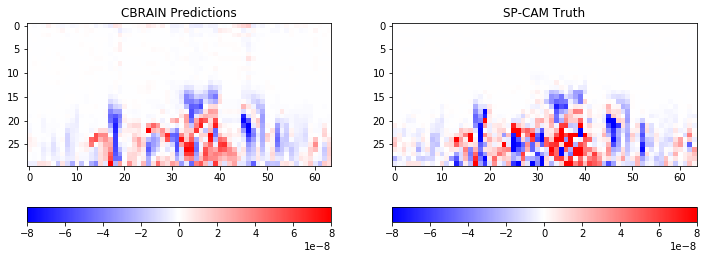

In [40]:
md.plot_double_yz(itime=0, ilon=0, var='PHQ', vmin=-8e-8, vmax=8e-8, cmap='bwr');

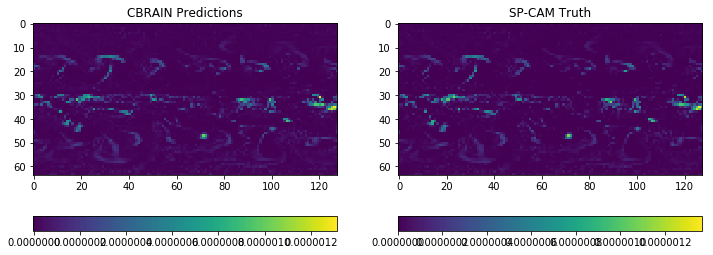

In [42]:
md.plot_double_xy(0, 0, 'PRECT');

### Compute statistics

Last but not least, we can compute statistics over the entire validation dataset.

In [43]:
md.compute_stats()

/home/s/S.Rasp/repositories/CBRAIN-CAM/cbrain/model_diagnostics/model_diagnostics.py:130: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/home/s/S.Rasp/repositories/CBRAIN-CAM/cbrain/model_diagnostics/model_diagnostics.py:136: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


Now there is a stats dictionary containing many statistics. If you want to implement your own statistics, you wil have to do so in the `compute_stats` method.

In [45]:
md.stats.keys()

dict_keys(['bias', 'mse', 'pred_mean', 'true_mean', 'pred_sqmean', 'true_sqmean', 'pred_var', 'true_var', 'r2', 'hor_tsqmean', 'hor_tmean', 'hor_mse', 'hor_tvar', 'hor_r2'])

One common statistic, for example, is the R2. So let's plot that. The R2 is averaged over time but all other dimensions are still available. Further, the vertical level is still stacked, so we will have to figure out the variable indices.

In [46]:
md.stats['r2'].shape

(64, 128, 218)

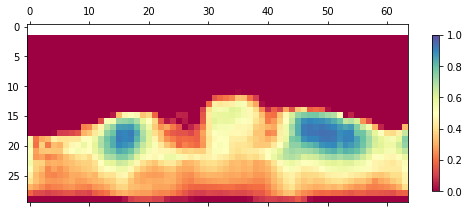

In [52]:
plt.matshow(md.stats['r2'][:, :, md.get_output_var_idx('PHQ')].mean(1).T, vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(shrink=0.7)

We also like looking at the horizontally averaged R2 for each variable.

In [53]:
md.stats['hor_r2'].shape

(218,)

In [55]:
md.valid_gen.output_vars[:7]

['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE']

In [64]:
# Get the vertical coordinate in pressure levels
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
P = (P[1:] + P[:-1]) / 2 / 100

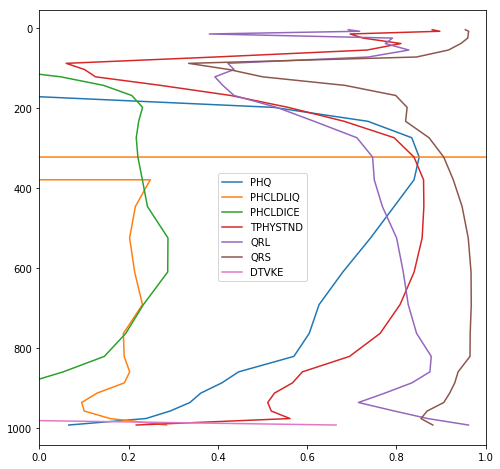

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
for v in md.valid_gen.output_vars[:7]:
    ax.plot(md.stats['hor_r2'][md.get_output_var_idx(v)], P, label=v)
ax.set_xlim(0, 1)
ax.invert_yaxis()
plt.legend()

## Last words

So this is the new version of cbrain. Feel free to fork you own branch and make changes. If you think this might be useful for others, just create a pull request.

Let me know if you have questions,
Stephan